##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Setup

In [2]:
%pip install -Uq "google-genai>=1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 3.6 MB/s eta 0:00:00


## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [3]:
from google import genai
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

## Download and inspect the PDF

Install the PDF processing tools. You don't need these to use the API, it's just used to display a screenshot of a page.

In [4]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.7 [186 kB]
Fetched 186 kB in 1s (303 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126332 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.7_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.7) ...
Setting up poppler-utils (22.02.0-2ubuntu0.7) ...
Processing triggers for man-db (2.10.2-1) ...


This PDF page is an article titled [Smoothly editing material properties of objects with text-to-image models and synthetic data](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) available on the Google Research Blog.

In [5]:
import pathlib

if not pathlib.Path('test.pdf').exists():
  !curl -o test.pdf https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6538k  100 6538k    0     0  20.3M      0 --:--:-- --:--:-- --:--:-- 20.3M


Look at one of the pages:

In [6]:
!pdftoppm test.pdf -f 1 -l 1 page-image -jpeg
!ls

page-image-1.jpg  sample_data  test.pdf


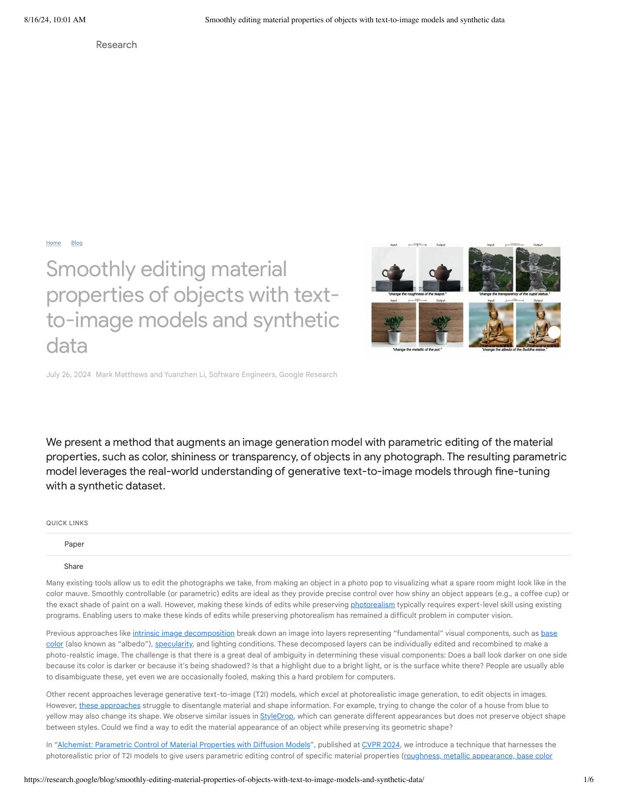

In [7]:
import PIL.Image

img = PIL.Image.open(f"page-image-1.jpg")
img.thumbnail([800, 800])
img

## Upload the file to the API

Start by uploading the PDF using the [File API](./File_API.ipynb).

In [8]:
file_ref = client.files.upload(file='test.pdf')

## Try it out

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).


In [9]:
MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

The pages of the PDF file are each passed to the model as a screenshot of the page plus the text extracted by OCR.

In [10]:
client.models.count_tokens(
    model=MODEL_ID,
    contents=[file_ref, 'Can you summarize this file as a bulleted list?']
).total_tokens

1560

In [11]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[file_ref, 'Can you summarize this file as a bulleted list?']
)

In [12]:
from IPython.display import Markdown

Markdown(response.text)

Here is a summary of the provided text as a bulleted list:

*   The post introduces a method for **smoothly editing material properties** (color, shininess, transparency) of objects in photographs.
*   This addresses the challenge of editing material properties while preserving photorealism and object shape, which is difficult with existing tools (like intrinsic image decomposition) or generative T2I methods (like StyleDrop) that struggle with disentanglement.
*   The method is called **Alchemist** and was presented at **CVPR 2024**.
*   It **augments a text-to-image (T2I) model** (specifically Stable Diffusion 1.5) to enable parametric control of material attributes.
*   The core of the technique is **fine-tuning the T2I model using a large synthetic dataset**.
*   The **synthetic dataset** is created by rendering 100 3D household objects using physically based rendering, systematically varying a single material property (like roughness or transparency) while keeping shape, lighting, and camera angle constant.
*   Each synthetic image is paired with a **scalar "edit strength"** value (-1 to +1) representing the degree of material change.
*   The model is fine-tuned to accept an image, instruction, and the edit strength value to learn how to perform the desired material edit.
*   The fine-tuned model **successfully generalizes to real-world images**, changing the material appearance of objects while preserving their shape and the image lighting.
*   Results demonstrate realistic edits, including correctly rendering background, hidden structures, and caustic effects for transparency changes.
*   A **user study** showed the method significantly outperformed a baseline (InstructPix2Pix) in terms of photorealism and user preference for the edits.
*   Potential **applications** include visualizing home decor changes, mocking up product designs, and enabling 3D-consistent material edits when combined with techniques like NeRF.
*   The authors are Mark Matthews and Yuanzhen Li from Google Research, describing work led by Prafull Sharma and others.

In addition, take a look at how the Gemini model responds when you ask questions about the images within the PDF.

In [13]:
response_2 = client.models.generate_content(
    model=MODEL_ID,
    contents=[file_ref, 'Can you explain the images on the first page of the document?']
)

In [14]:
Markdown(response_2.text)

Based on the first page of the document, the images illustrate examples of the material property editing method being presented in the blog post.

Here's a breakdown:

1.  **Layout:** The images are presented in pairs, labeled **Input** and **Output**. The Input is the original image, and the Output is the image after applying an edit using the described method. Below the Output images are captions specifying the text instruction used to generate the edit.

2.  **What they show:** Each pair demonstrates changing a specific material property of an object within the image while ideally preserving other aspects like the object's shape, the lighting, and the background scene.

    *   **Top Left Pair (Teapot):** Shows changing the **roughness** of the teapot. The output teapot appears duller and less reflective than the input.
    *   **Top Right Pair (Cupid Statue):** Shows changing the **transparency** of the Cupid statue. The output statue is partially see-through, revealing the background behind it.
    *   **Bottom Left Pair (Potted Plant):** Shows changing the **metallic** property of the pot. The output pot appears shiny and metallic.
    *   **Bottom Right Pair (Buddha Statue):** Shows changing the **albedo** (base color) of the Buddha statue. The output statue has a golden hue instead of the original reddish-brown stone color.

In summary, these images are initial visual demonstrations of the technique's ability to perform precise, controllable edits on the material appearance of objects in photographs, such as making them more or less rough, transparent, metallic, or changing their color.

If you observe the area of the header of the article, you can see that the model captures what is happening.

## Learning more

The File API lets you upload a variety of multimodal MIME types, including images, audio, and video formats. The File API handles inputs that can be used to generate content with `model.generateContent` or `model.streamGenerateContent`.

The File API accepts files under 2GB in size and can store up to 20GB of files per project. Files last for 2 days and cannot be downloaded from the API.

* Learn more about prompting with [media files](https://ai.google.dev/gemini-api/docs/file-prompting-strategies) in the docs, including the supported formats and maximum length.
* Learn more about to extract structured outputs from PDFs in the [Structured outputs on invoices and forms](https://github.com/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) example.
